## 이파트에서는 유저가 파티에 참여한 시간대를 feature 두어 보통 어떤 클래스의 유저가 어느 시간대에 주로 활동을 하는지 알아보기 위해 만들었습니다.

> 가정. 클래스 별로 파티 참여 빈도에서 차이나고, 시간대별로도 차이가 날 것이다.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from itertools import chain

In [89]:
from scipy.stats import kstest
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations
from sklearn.preprocessing import QuantileTransformer

In [91]:
from pprint import pprint

In [4]:
#정규성 검정과 클래스간의 차이를 보기위한 함수 생성

def new_variable_checker(total, var):
    
    col_name = var.name
#     #### 표준화
#     var = (var - var.mean())/var.std()
    
    df = total.loc[:,('label',col_name)]
    #### rank transformation
    q_t = QuantileTransformer()
    df[col_name] = pd.Series(q_t.fit_transform(df[col_name].values.reshape(-1, 1)).reshape(-1),name = col_name)
    
    #### 검정을 위한 표 만들기

    table = df.pivot(columns='label',values = col_name)
    table = pd.concat((table['retained'].dropna().reset_index(drop = True),
               table['2month'].dropna().reset_index(drop = True),
               table['month'].dropna().reset_index(drop = True),
               table['week'].dropna().reset_index(drop = True)),axis = 1)
    
    #### 정규성 검정
    _, n_0 = kstest(table['retained'],'norm')
    _, n_1 = kstest(table['2month'],'norm')
    _, n_2 = kstest(table['month'],'norm')
    _, n_3 = kstest(table['week'],'norm')
    
    #### box plot
    table.plot.box()
    
    ##### 네 집단 사이의 평균검정.
    
    if (n_0 <0.05) and (n_1 <0.05) and (n_2 <0.05) and (n_3 <0.05): 
        pprint("변수 %s는 정규성을 가정할 수 없습니다."%col_name)
        print(n_0,n_1,n_2,n_3)
        print()
        s, p = kruskal(table['retained'],table['2month'],table['month'],table['week'])
    
        if p >= 0.1: # 차이 없음
            pprint('통계적으로 네 집단의 차이가 유의하지 않음.')
            return
        else:
            pprint('통계적으로 네 집단의 차이가 유의함.')
            
        #### Mahn-whiteney검정
        mw_result = []
        for c1, c2 in combinations(table.columns,2):
            u, p = mannwhitneyu(table[c1],table[c2],alternative='two-sided')
            mw_result.append((c1,c2,p))
            
        result = pd.DataFrame(mw_result,columns=['Group1','Group2','reject'])
        result['reject'] = result.reject.apply(lambda x: True if x < (0.1/6) else False) #본페르니
        pprint(result)

    else: # Normal Distribution
        pprint("변수 %s의 모집단은 정규분포를 따릅니다."%col_name)
        print()
        model = ols(col_name + ' ~ label', df).fit()
        result = anova_lm(model)
        pprint(result)
        p = result.iloc[0,-1]
        
        if p >= 0.1: # 차이 없음
            pprint('통계적으로 네 집단의 차이가 유의하지 않음.')
            return
        else:
            pprint('통계적으로 네 집단의 차이가 유의함.')
        
        #### tukey hsd 검정.(사후검정)
        result = pairwise_tukeyhsd(df.iloc[:,1], df.iloc[:,0],alpha=0.1)
        print(result.summary())
        print()
        result.plot_simultaneous()
    
    return result.reject

In [145]:
train_activity=pd.read_csv('../transformed/real_only_activity_int.csv')
test_activity=pd.read_csv('../transformed/test_real_datas_int.csv')

train_party=pd.read_csv('../lite_data/train_party_lite.csv')
test_party=pd.read_csv('../lite_data/test_party_lite.csv')

In [21]:
train_label=pd.read_csv('../lite_data/train_label_lite.csv')

## 앞서 말씀드렸다 시피 activity 변수에서 어떤 유저의 특정 주차에 활동 기록이 없음에도 불구하고 파티참여가 뜨는 이력이 있으므로 데이터 정제 단계에서 오류가 있었다고 판단했습니다.


## 마지막 시간대가 5시 이므로 각 주차의 첫번째 날에 새벽 0시~6시에 생성된 파티는 해당 주차의 전주(party_start_week-1)로 하고 진행했습니다.

In [6]:
#test과 train set에 있는 파티목록 서로 합친 뒤에 중복 제거
train_party=pd.concat([train_party,test_party],axis=0).drop_duplicates().reset_index().iloc[:,1:]


# 첫번째 날에 새벽 00~ 6시에 활동한 이력이 있는 경우 해당 주차의 전주차로 집계
train_party.loc[ (train_party['party_start_day']==1) & (pd.to_timedelta(train_party['party_start_time'])<pd.Timedelta(6,'h')),'party_start_week']+=-1

In [7]:
# 시간대만 따로 저장
train_party['party_time_type']=train_party.party_start_time.str[0:2]

In [8]:
target=train_party.loc[:,['party_members_acc_id','party_start_week','party_time_type']]

In [9]:
party_list=[[(p,t) for p in target.iloc[i,0].split(',')] for i, t in enumerate(target.party_time_type)]

In [10]:
a=pd.DataFrame(list(chain(*party_list)),columns=['new_id','party_time_type'])

In [11]:
a.head()

,new_id,party_time_type
0,ot160647,09
1,ot47783,09
2,tr53166,09
3,ot200260,09
4,ot148400,09


In [12]:
party_member_list=[[(p,t) for p in target.iloc[i,0].split(',')] for i, t in enumerate(target.party_members_acc_id)]

In [13]:
party_list2 = [[(p,t) for p in target.iloc[i,0].split(',')] for i, t in enumerate(target.party_start_week)]

In [14]:
b=pd.DataFrame(list(chain(*party_list2)),columns=['new_id','wk'])

In [15]:
b.head()

,new_id,wk
0,ot160647,1
1,ot47783,1
2,tr53166,1
3,ot200260,1
4,ot148400,1


In [16]:
# 데이터 프레임 a 의 순서와 b의 순서가같으므로 하나로 concatenate
total_result=pd.concat([b,a],axis=1).iloc[:,[0,1,3]]

In [17]:
# 그 중에 
tr_party=total_result[total_result.new_id.str.contains('tr')]


In [125]:
# 피봇 테이블을 통해 유저가 각 주차에 어느시간대에 파티참여를 했는지 count
ultimo_train=pd.pivot_table(tr_party,aggfunc=len,columns='party_time_type',index=['new_id','wk']).fillna(0).reset_index()

In [22]:
ultimo_train.head(10)

party_time_type,new_id,wk,00,01,02,03,04,05,06,07,...,14,15,16,17,18,19,20,21,22,23
0,tr1,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0
1,tr100,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,3.0,1.0,2.0,1.0,2.0,0.0,1.0,2.0
2,tr100,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,4.0,0.0,1.0,0.0,1.0,1.0
3,tr1000,8,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,...,2.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
4,tr10000,8,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,1.0,1.0,7.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
5,tr10001,8,4.0,8.0,4.0,2.0,2.0,2.0,3.0,0.0,...,2.0,3.0,2.0,5.0,4.0,0.0,5.0,0.0,7.0,5.0
6,tr10002,1,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0
7,tr10002,2,0.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0
8,tr10002,3,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,tr10002,6,0.0,0.0,0.0,1.0,4.0,5.0,4.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [236]:
ultimo_train=train_merge.groupby('new_id').mean()

In [44]:
train_party_for_everyhour=pd.merge(train_label,ultimo_train,on='new_id')

In [70]:
train_party_for_everyhour.columns=['new_id','label','wk', 'hr_00', 'hr_01', 'hr_02', 'hr_03', 'hr_04', 'hr_05', 'hr_06', 'hr_07',
       'hr_08', 'hr_09', 'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19',
       'hr_20', 'hr_21', 'hr_22', 'hr_23']

In [124]:
# 클래스별 파티참여 시간대 횟수

train_party_for_everyhour.head(10)

,new_id,label,wk,hr_00,hr_01,hr_02,hr_03,hr_04,hr_05,hr_06,...,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23
0,tr1,week,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0
1,tr2,retained,5,1.0,1.0,5.0,6.0,6.0,4.0,2.0,...,4.0,0.0,1.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0
2,tr2,retained,6,7.0,4.0,5.0,1.0,6.0,2.0,10.0,...,3.0,0.0,7.0,3.0,3.0,7.0,1.0,4.0,4.0,4.0
3,tr2,retained,8,2.0,2.0,2.0,1.0,1.0,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0
4,tr3,week,8,0.0,1.0,2.0,2.0,7.0,5.0,1.0,...,2.0,0.0,0.0,0.0,6.0,3.0,2.0,5.0,2.0,2.0
5,tr4,retained,1,9.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,6.0,6.0,10.0,3.0,8.0,7.0,7.0,8.0
6,tr4,retained,2,5.0,0.0,6.0,3.0,4.0,3.0,6.0,...,1.0,2.0,1.0,3.0,7.0,6.0,1.0,4.0,1.0,3.0
7,tr4,retained,3,0.0,0.0,4.0,3.0,3.0,2.0,8.0,...,7.0,8.0,4.0,0.0,0.0,2.0,0.0,1.0,2.0,0.0
8,tr4,retained,4,7.0,3.0,7.0,0.0,0.0,3.0,6.0,...,0.0,6.0,0.0,4.0,8.0,5.0,5.0,3.0,0.0,3.0
9,tr4,retained,5,2.0,4.0,1.0,1.0,1.0,0.0,4.0,...,2.0,0.0,1.0,4.0,5.0,5.0,4.0,8.0,5.0,5.0


/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


'변수 hr_00의 모집단은 정규분포를 따릅니다.'

                df        sum_sq    mean_sq           F         PR(>F)
label          3.0    211.702025  70.567342  477.807967  1.383118e-309
Residual  240020.0  35448.495074   0.147690         NaN            NaN
'통계적으로 네 집단의 차이가 유의함.'
Multiple Comparison of Means - Tukey HSD,FWER=0.10
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
 2month   month   -0.0437  -0.0508 -0.0366  True 
 2month  retained  0.0371   0.0308  0.0434  True 
 2month    week    0.0034  -0.0034  0.0101 False 
 month   retained  0.0808   0.0758  0.0858  True 
 month     week    0.0471   0.0415  0.0526  True 
retained   week   -0.0337  -0.0382 -0.0293  True 
-------------------------------------------------



array([ True,  True, False,  True,  True,  True])

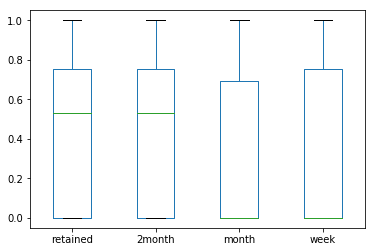

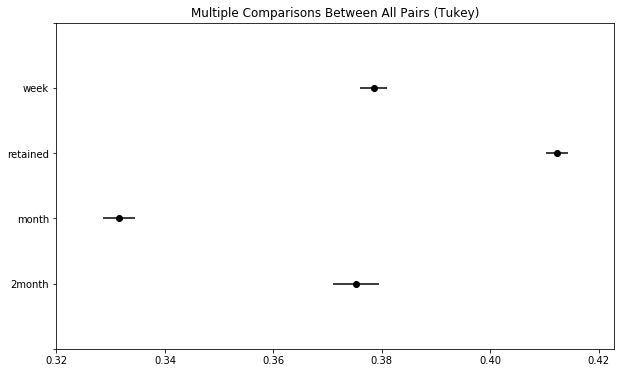

In [93]:
new_variable_checker(train_party_for_everyhour.loc[:,['new_id','hr_00','label']], train_party_for_everyhour.loc[:,'hr_00'])

/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


'변수 hr_01의 모집단은 정규분포를 따릅니다.'

                df        sum_sq    mean_sq           F         PR(>F)
label          3.0     74.696328  24.898776  161.678434  1.065325e-104
Residual  240020.0  36963.521010   0.154002         NaN            NaN
'통계적으로 네 집단의 차이가 유의함.'
Multiple Comparison of Means - Tukey HSD,FWER=0.10
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
 2month   month   -0.0224  -0.0297 -0.0151  True 
 2month  retained -0.0056  -0.0121  0.0008 False 
 2month    week    0.0284   0.0215  0.0353  True 
 month   retained  0.0168   0.0117  0.0219  True 
 month     week    0.0508   0.0451  0.0564  True 
retained   week    0.034    0.0295  0.0385  True 
-------------------------------------------------



array([ True, False,  True,  True,  True,  True])

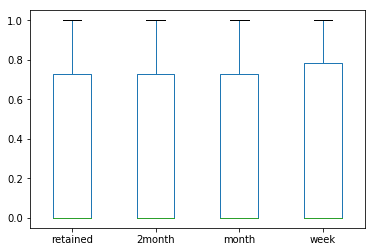

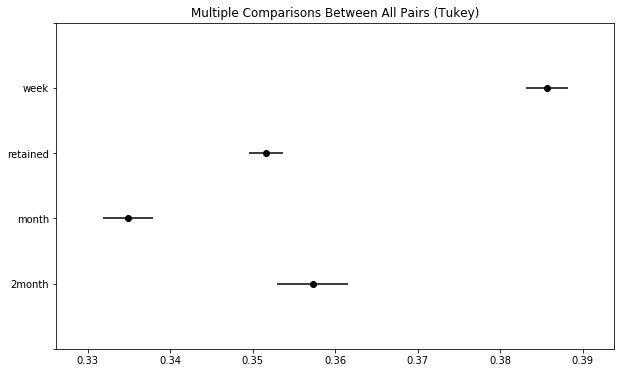

In [94]:
new_variable_checker(train_party_for_everyhour.loc[:,['new_id','hr_01','label']], train_party_for_everyhour.loc[:,'hr_01'])

/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


'변수 hr_02의 모집단은 정규분포를 따릅니다.'

                df        sum_sq     mean_sq            F  PR(>F)
label          3.0    531.402587  177.134196  1134.934852     0.0
Residual  240020.0  37460.960513    0.156074          NaN     NaN
'통계적으로 네 집단의 차이가 유의함.'
Multiple Comparison of Means - Tukey HSD,FWER=0.10
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
 2month   month    0.0046  -0.0028  0.0119 False 
 2month  retained -0.0472  -0.0537 -0.0408  True 
 2month    week    0.068    0.061   0.0749  True 
 month   retained -0.0518  -0.0569 -0.0467  True 
 month     week    0.0634   0.0577  0.0691  True 
retained   week    0.1152   0.1107  0.1198  True 
-------------------------------------------------



array([False,  True,  True,  True,  True,  True])

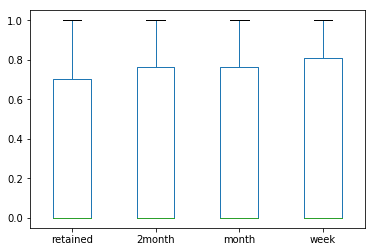

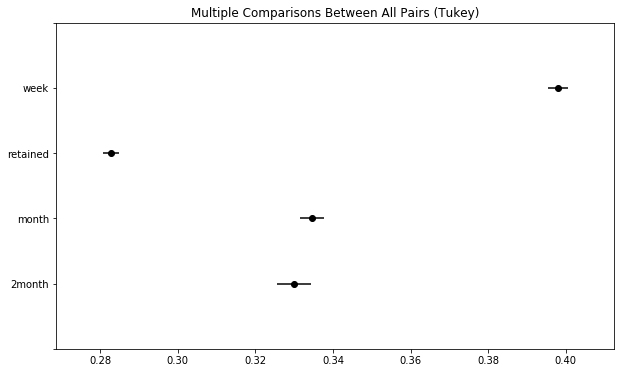

In [95]:
new_variable_checker(train_party_for_everyhour.loc[:,['new_id','hr_02','label']], train_party_for_everyhour.loc[:,'hr_02'])

/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


'변수 hr_03의 모집단은 정규분포를 따릅니다.'

                df        sum_sq     mean_sq            F  PR(>F)
label          3.0   1176.649071  392.216357  2552.315664     0.0
Residual  240020.0  36884.062299    0.153671          NaN     NaN
'통계적으로 네 집단의 차이가 유의함.'
Multiple Comparison of Means - Tukey HSD,FWER=0.10
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
 2month   month    0.0196   0.0123  0.0268  True 
 2month  retained -0.0765   -0.083 -0.0701  True 
 2month    week    0.0922   0.0853  0.0991  True 
 month   retained -0.0961  -0.1012  -0.091  True 
 month     week    0.0726   0.067   0.0783  True 
retained   week    0.1687   0.1642  0.1732  True 
-------------------------------------------------



array([ True,  True,  True,  True,  True,  True])

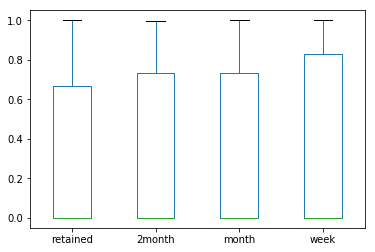

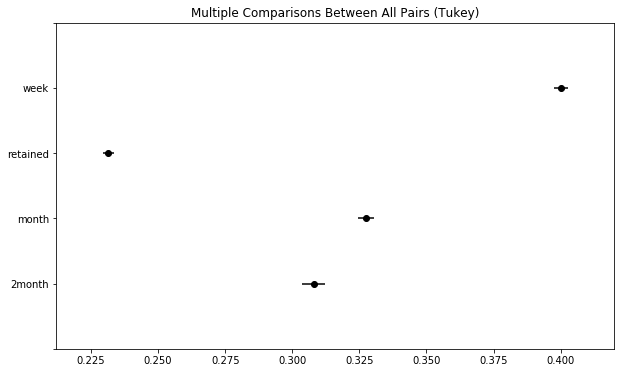

In [96]:
new_variable_checker(train_party_for_everyhour.loc[:,['new_id','hr_03','label']], train_party_for_everyhour.loc[:,'hr_03'])

/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


'변수 hr_04의 모집단은 정규분포를 따릅니다.'

                df        sum_sq     mean_sq            F  PR(>F)
label          3.0   1728.044747  576.014916  3849.129773     0.0
Residual  240020.0  35918.534372    0.149648          NaN     NaN
'통계적으로 네 집단의 차이가 유의함.'
Multiple Comparison of Means - Tukey HSD,FWER=0.10
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
 2month   month    0.0353   0.0281  0.0425  True 
 2month  retained -0.0901  -0.0964 -0.0837  True 
 2month    week    0.1125   0.1057  0.1193  True 
 month   retained -0.1253  -0.1304 -0.1203  True 
 month     week    0.0772   0.0716  0.0828  True 
retained   week    0.2025   0.1981  0.207   True 
-------------------------------------------------



array([ True,  True,  True,  True,  True,  True])

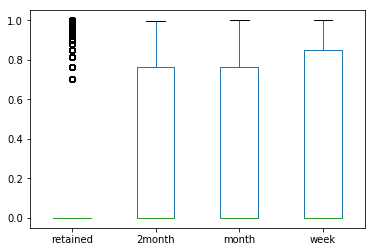

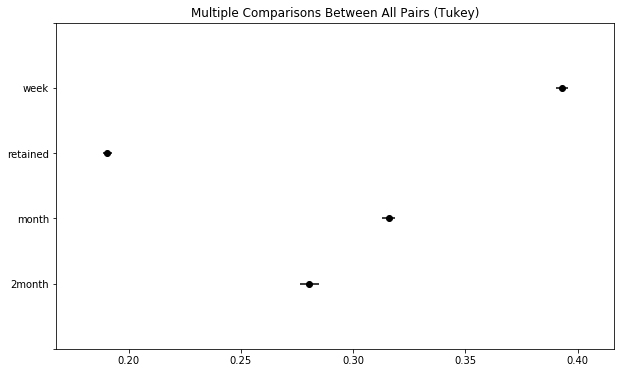

In [97]:
new_variable_checker(train_party_for_everyhour.loc[:,['new_id','hr_04','label']], train_party_for_everyhour.loc[:,'hr_04'])

/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


'변수 hr_05의 모집단은 정규분포를 따릅니다.'

                df        sum_sq     mean_sq            F  PR(>F)
label          3.0   1930.392986  643.464329  4495.385518     0.0
Residual  240020.0  34356.187589    0.143139          NaN     NaN
'통계적으로 네 집단의 차이가 유의함.'
Multiple Comparison of Means - Tukey HSD,FWER=0.10
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
 2month   month    0.041    0.0339  0.048   True 
 2month  retained -0.0908   -0.097 -0.0846  True 
 2month    week    0.1235   0.1169  0.1302  True 
 month   retained -0.1317  -0.1367 -0.1268  True 
 month     week    0.0826   0.0771  0.088   True 
retained   week    0.2143    0.21   0.2187  True 
-------------------------------------------------



array([ True,  True,  True,  True,  True,  True])

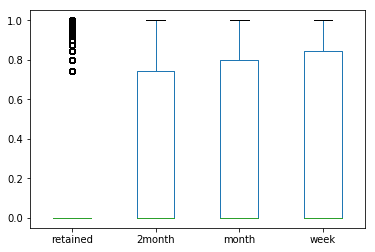

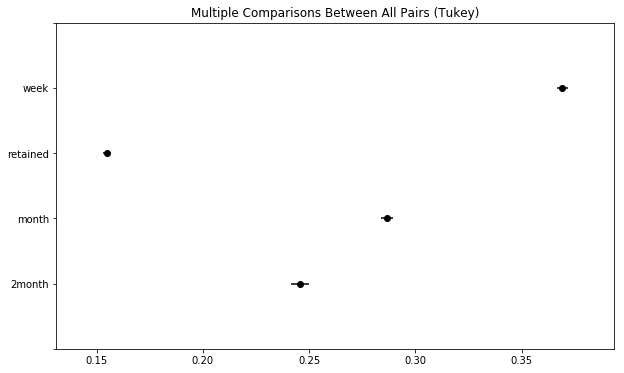

In [98]:
new_variable_checker(train_party_for_everyhour.loc[:,['new_id','hr_05','label']], train_party_for_everyhour.loc[:,'hr_05'])

/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


'변수 hr_06의 모집단은 정규분포를 따릅니다.'

                df        sum_sq     mean_sq            F  PR(>F)
label          3.0   2115.443919  705.147973  5223.282051     0.0
Residual  240020.0  32402.924983    0.135001          NaN     NaN
'통계적으로 네 집단의 차이가 유의함.'
Multiple Comparison of Means - Tukey HSD,FWER=0.10
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
 2month   month    0.0561   0.0493  0.0629  True 
 2month  retained -0.0534  -0.0594 -0.0473  True 
 2month    week    0.1747   0.1682  0.1811  True 
 month   retained -0.1094  -0.1142 -0.1047  True 
 month     week    0.1186   0.1133  0.1239  True 
retained   week    0.228    0.2238  0.2323  True 
-------------------------------------------------



array([ True,  True,  True,  True,  True,  True])

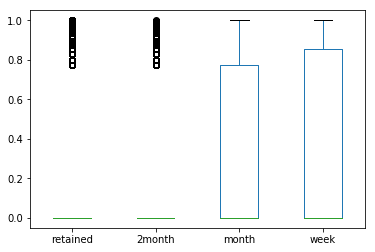

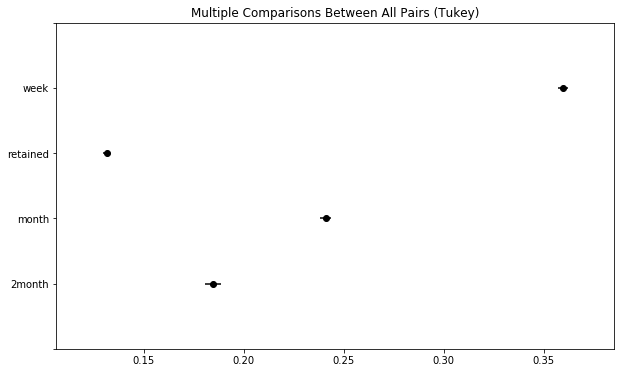

In [99]:
new_variable_checker(train_party_for_everyhour.loc[:,['new_id','hr_06','label']], train_party_for_everyhour.loc[:,'hr_06'])

/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


'변수 hr_07의 모집단은 정규분포를 따릅니다.'

                df        sum_sq     mean_sq            F  PR(>F)
label          3.0   1929.165599  643.055200  4712.042832     0.0
Residual  240020.0  32755.667664    0.136471          NaN     NaN
'통계적으로 네 집단의 차이가 유의함.'
Multiple Comparison of Means - Tukey HSD,FWER=0.10
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
 2month   month    0.0648   0.058   0.0717  True 
 2month  retained  -0.053  -0.0591  -0.047  True 
 2month    week    0.1628   0.1563  0.1693  True 
 month   retained -0.1179  -0.1227 -0.1131  True 
 month     week    0.098    0.0927  0.1033  True 
retained   week    0.2158   0.2116  0.2201  True 
-------------------------------------------------



array([ True,  True,  True,  True,  True,  True])

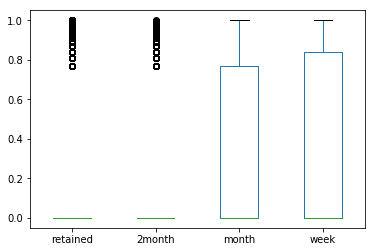

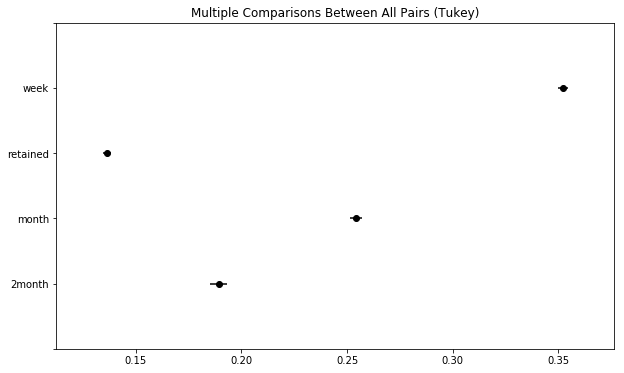

In [100]:
new_variable_checker(train_party_for_everyhour.loc[:,['new_id','hr_07','label']], train_party_for_everyhour.loc[:,'hr_07'])

/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


'변수 hr_08의 모집단은 정규분포를 따릅니다.'

                df        sum_sq     mean_sq            F  PR(>F)
label          3.0   1508.534267  502.844756  3573.090645     0.0
Residual  240020.0  33778.263760    0.140731          NaN     NaN
'통계적으로 네 집단의 차이가 유의함.'
Multiple Comparison of Means - Tukey HSD,FWER=0.10
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
 2month   month    0.0625   0.0556  0.0695  True 
 2month  retained -0.0433  -0.0494 -0.0371  True 
 2month    week    0.147    0.1404  0.1536  True 
 month   retained -0.1058  -0.1107 -0.1009  True 
 month     week    0.0845   0.0791  0.0899  True 
retained   week    0.1902   0.1859  0.1946  True 
-------------------------------------------------



array([ True,  True,  True,  True,  True,  True])

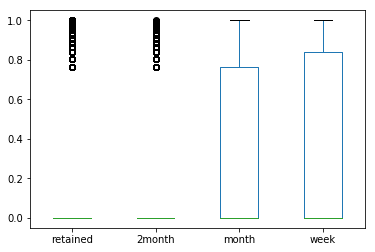

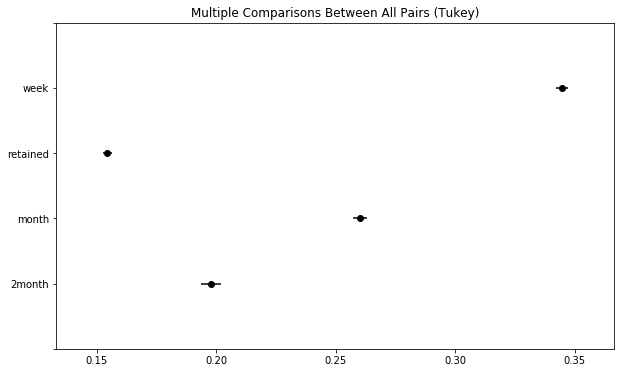

In [101]:
new_variable_checker(train_party_for_everyhour.loc[:,['new_id','hr_08','label']], train_party_for_everyhour.loc[:,'hr_08'])

/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


'변수 hr_09의 모집단은 정규분포를 따릅니다.'

                df        sum_sq     mean_sq            F  PR(>F)
label          3.0    753.699929  251.233310  1693.536702     0.0
Residual  240020.0  35606.561630    0.148348          NaN     NaN
'통계적으로 네 집단의 차이가 유의함.'
Multiple Comparison of Means - Tukey HSD,FWER=0.10
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
 2month   month    0.0531   0.0459  0.0602  True 
 2month  retained  -0.022  -0.0284 -0.0157  True 
 2month    week    0.1114   0.1047  0.1182  True 
 month   retained -0.0751  -0.0801 -0.0701  True 
 month     week    0.0584   0.0528  0.0639  True 
retained   week    0.1335   0.129   0.1379  True 
-------------------------------------------------



array([ True,  True,  True,  True,  True,  True])

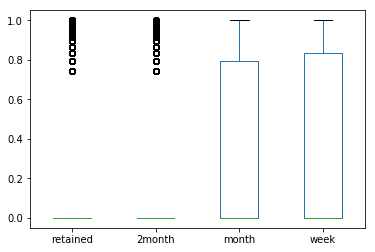

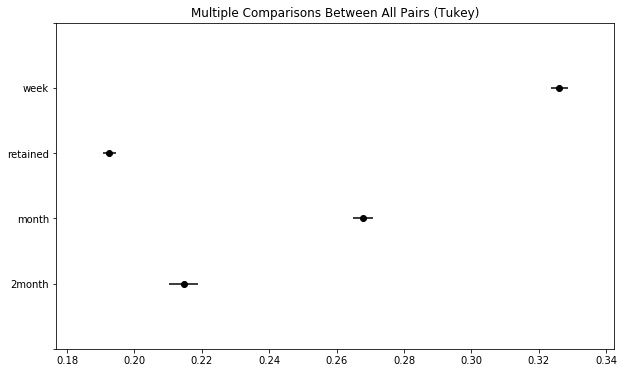

In [102]:
new_variable_checker(train_party_for_everyhour.loc[:,['new_id','hr_09','label']], train_party_for_everyhour.loc[:,'hr_09'])

/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


'변수 hr_10의 모집단은 정규분포를 따릅니다.'

                df        sum_sq     mean_sq           F  PR(>F)
label          3.0    392.199627  130.733209  842.104207     0.0
Residual  240020.0  37262.116246    0.155246         NaN     NaN
'통계적으로 네 집단의 차이가 유의함.'
Multiple Comparison of Means - Tukey HSD,FWER=0.10
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
 2month   month    0.0428   0.0355  0.0501  True 
 2month  retained  0.0071   0.0006  0.0136  True 
 2month    week    0.1018   0.0949  0.1088  True 
 month   retained -0.0357  -0.0408 -0.0306  True 
 month     week    0.059    0.0534  0.0647  True 
retained   week    0.0947   0.0902  0.0993  True 
-------------------------------------------------



array([ True,  True,  True,  True,  True,  True])

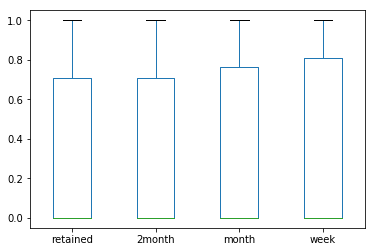

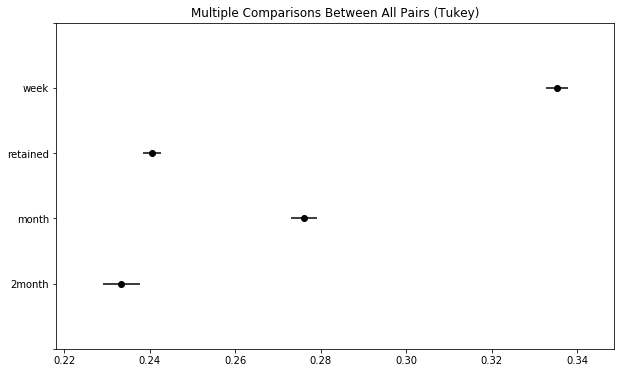

In [103]:
new_variable_checker(train_party_for_everyhour.loc[:,['new_id','hr_10','label']], train_party_for_everyhour.loc[:,'hr_10'])

/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


'변수 hr_11의 모집단은 정규분포를 따릅니다.'

                df        sum_sq    mean_sq           F         PR(>F)
label          3.0    180.617379  60.205793  381.606265  2.675420e-247
Residual  240020.0  37867.812425   0.157769         NaN            NaN
'통계적으로 네 집단의 차이가 유의함.'
Multiple Comparison of Means - Tukey HSD,FWER=0.10
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
 2month   month    0.0252   0.0178 0.0326  True 
 2month  retained  0.0208   0.0143 0.0274  True 
 2month    week    0.0801   0.0731 0.0871  True 
 month   retained -0.0044  -0.0095 0.0008 False 
 month     week    0.0549   0.0492 0.0606  True 
retained   week    0.0593   0.0547 0.0638  True 
------------------------------------------------



array([ True,  True,  True, False,  True,  True])

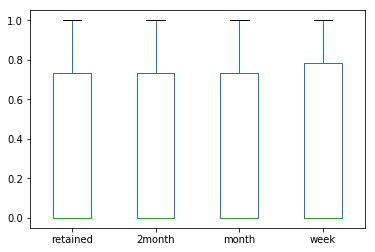

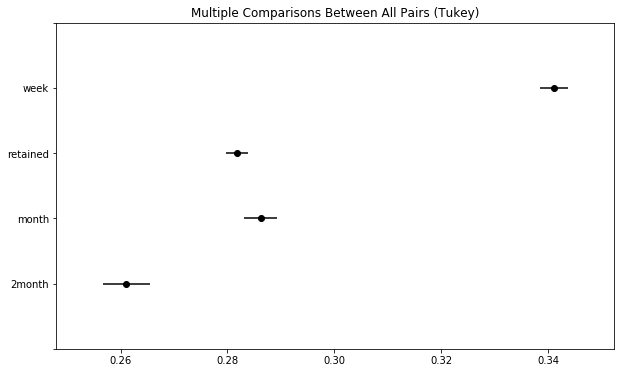

In [104]:
new_variable_checker(train_party_for_everyhour.loc[:,['new_id','hr_11','label']], train_party_for_everyhour.loc[:,'hr_11'])

/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


'변수 hr_12의 모집단은 정규분포를 따릅니다.'

                df        sum_sq    mean_sq          F         PR(>F)
label          3.0     94.748804  31.582935  199.56877  2.787302e-129
Residual  240020.0  37984.580522   0.158256        NaN            NaN
'통계적으로 네 집단의 차이가 유의함.'
Multiple Comparison of Means - Tukey HSD,FWER=0.10
 group1   group2  meandiff lower  upper  reject
-----------------------------------------------
 2month   month    0.0125  0.0051 0.0199  True 
 2month  retained  0.0247  0.0182 0.0312  True 
 2month    week    0.0605  0.0535 0.0675  True 
 month   retained  0.0122  0.007  0.0174  True 
 month     week    0.048   0.0423 0.0537  True 
retained   week    0.0358  0.0313 0.0404  True 
-----------------------------------------------



array([ True,  True,  True,  True,  True,  True])

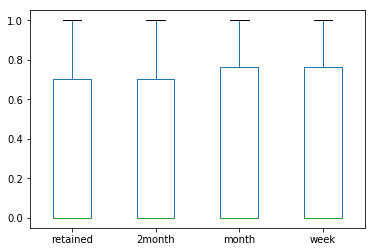

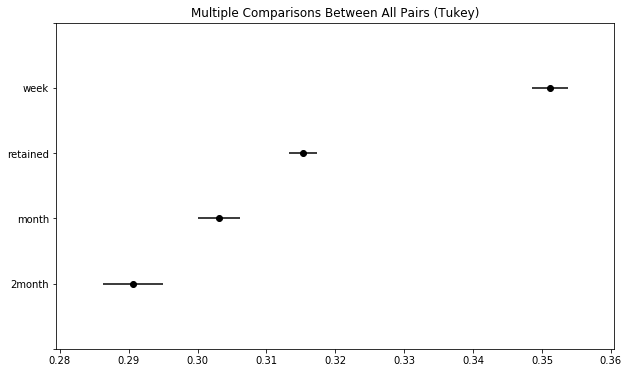

In [105]:
new_variable_checker(train_party_for_everyhour.loc[:,['new_id','hr_12','label']], train_party_for_everyhour.loc[:,'hr_12'])

/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


'변수 hr_13의 모집단은 정규분포를 따릅니다.'

                df        sum_sq    mean_sq          F         PR(>F)
label          3.0    105.947948  35.315983  225.37813  5.042891e-146
Residual  240020.0  37610.313718   0.156697        NaN            NaN
'통계적으로 네 집단의 차이가 유의함.'
Multiple Comparison of Means - Tukey HSD,FWER=0.10
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
 2month   month    0.0023   -0.005 0.0097 False 
 2month  retained  0.0494   0.0429 0.0559  True 
 2month    week    0.0463   0.0394 0.0533  True 
 month   retained  0.0471   0.0419 0.0522  True 
 month     week    0.044    0.0383 0.0497  True 
retained   week   -0.0031  -0.0076 0.0015 False 
------------------------------------------------



array([False,  True,  True,  True,  True, False])

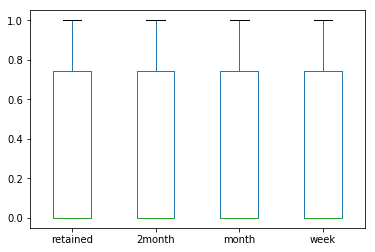

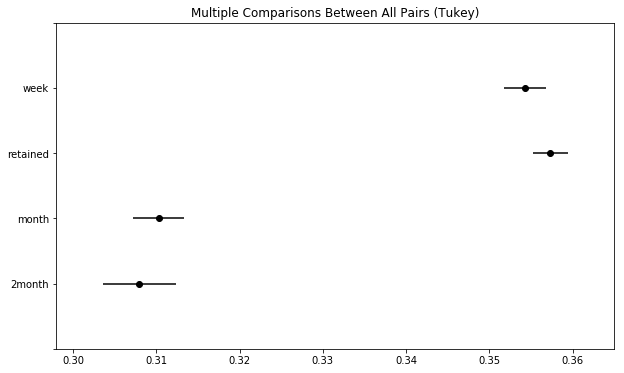

In [106]:
new_variable_checker(train_party_for_everyhour.loc[:,['new_id','hr_13','label']], train_party_for_everyhour.loc[:,'hr_13'])

/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


'변수 hr_14의 모집단은 정규분포를 따릅니다.'

                df        sum_sq    mean_sq           F         PR(>F)
label          3.0    154.856549  51.618850  333.465387  4.166281e-216
Residual  240020.0  37153.949967   0.154795         NaN            NaN
'통계적으로 네 집단의 차이가 유의함.'
Multiple Comparison of Means - Tukey HSD,FWER=0.10
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
 2month   month    0.0054  -0.0019 0.0127 False 
 2month  retained  0.0641   0.0576 0.0705  True 
 2month    week    0.0465   0.0396 0.0535  True 
 month   retained  0.0586   0.0535 0.0638  True 
 month     week    0.0411   0.0355 0.0468  True 
retained   week   -0.0175   -0.022 -0.013  True 
------------------------------------------------



array([False,  True,  True,  True,  True,  True])

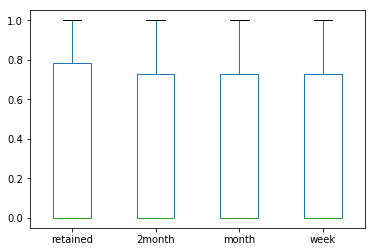

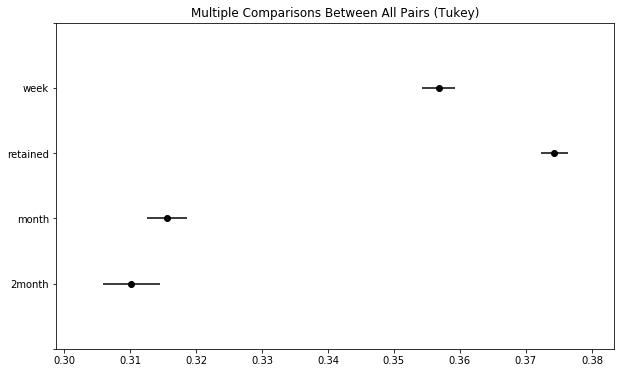

In [107]:
new_variable_checker(train_party_for_everyhour.loc[:,['new_id','hr_14','label']], train_party_for_everyhour.loc[:,'hr_14'])

/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


'변수 hr_15의 모집단은 정규분포를 따릅니다.'

                df        sum_sq    mean_sq           F         PR(>F)
label          3.0    178.118066  59.372689  387.673847  3.140732e-251
Residual  240020.0  36759.334878   0.153151         NaN            NaN
'통계적으로 네 집단의 차이가 유의함.'
Multiple Comparison of Means - Tukey HSD,FWER=0.10
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
 2month   month    0.0076   0.0003  0.0148  True 
 2month  retained  0.068    0.0616  0.0745  True 
 2month    week    0.0291   0.0222  0.036   True 
 month   retained  0.0605   0.0554  0.0655  True 
 month     week    0.0215   0.0159  0.0271  True 
retained   week   -0.0389  -0.0434 -0.0344  True 
-------------------------------------------------



array([ True,  True,  True,  True,  True,  True])

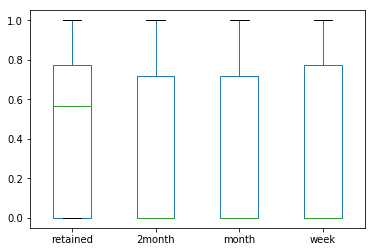

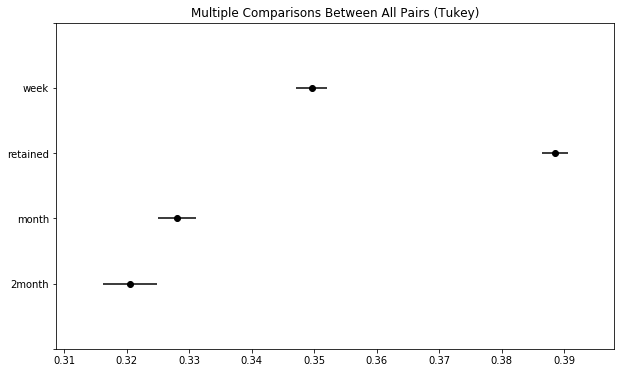

In [108]:
new_variable_checker(train_party_for_everyhour.loc[:,['new_id','hr_15','label']], train_party_for_everyhour.loc[:,'hr_15'])

/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


'변수 hr_16의 모집단은 정규분포를 따릅니다.'

                df        sum_sq    mean_sq           F  PR(>F)
label          3.0    254.521701  84.840567  563.831433     0.0
Residual  240020.0  36116.171730   0.150472         NaN     NaN
'통계적으로 네 집단의 차이가 유의함.'
Multiple Comparison of Means - Tukey HSD,FWER=0.10
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
 2month   month    0.0047  -0.0025  0.0119 False 
 2month  retained  0.0768   0.0704  0.0831  True 
 2month    week    0.0249   0.0181  0.0317  True 
 month   retained  0.0721   0.0671  0.0771  True 
 month     week    0.0203   0.0147  0.0258  True 
retained   week   -0.0518  -0.0563 -0.0474  True 
-------------------------------------------------



array([False,  True,  True,  True,  True,  True])

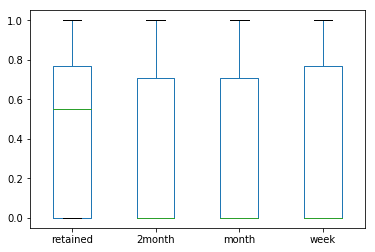

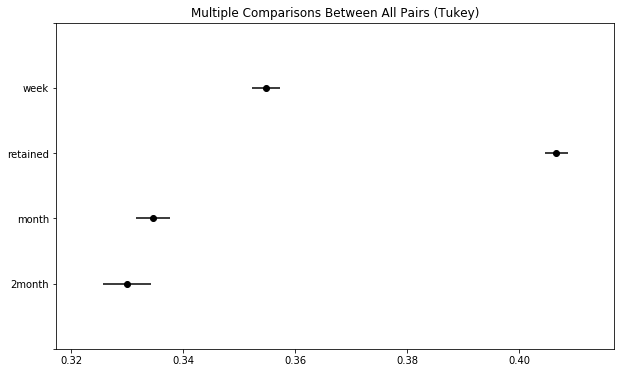

In [109]:
new_variable_checker(train_party_for_everyhour.loc[:,['new_id','hr_16','label']], train_party_for_everyhour.loc[:,'hr_16'])

/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


'변수 hr_17의 모집단은 정규분포를 따릅니다.'

                df        sum_sq     mean_sq           F  PR(>F)
label          3.0    305.674035  101.891345  688.691828     0.0
Residual  240020.0  35510.746014    0.147949         NaN     NaN
'통계적으로 네 집단의 차이가 유의함.'
Multiple Comparison of Means - Tukey HSD,FWER=0.10
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
 2month   month    0.0007  -0.0065 0.0078 False 
 2month  retained  0.0754   0.0691 0.0817  True 
 2month    week    0.008    0.0012 0.0147  True 
 month   retained  0.0747   0.0697 0.0797  True 
 month     week    0.0073   0.0018 0.0129  True 
retained   week   -0.0674  -0.0718 -0.063  True 
------------------------------------------------



array([False,  True,  True,  True,  True,  True])

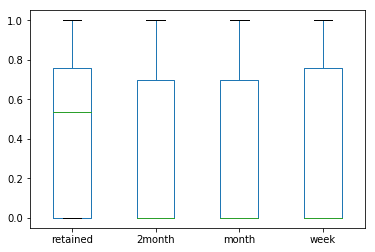

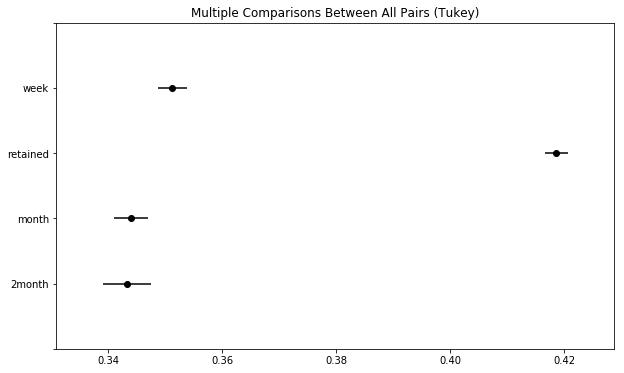

In [110]:
new_variable_checker(train_party_for_everyhour.loc[:,['new_id','hr_17','label']], train_party_for_everyhour.loc[:,'hr_17'])

/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


'변수 hr_18의 모집단은 정규분포를 따릅니다.'

                df        sum_sq     mean_sq         F  PR(>F)
label          3.0    373.598136  124.532712  864.5971     0.0
Residual  240020.0  34571.410783    0.144036       NaN     NaN
'통계적으로 네 집단의 차이가 유의함.'
Multiple Comparison of Means - Tukey HSD,FWER=0.10
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
 2month   month    -0.017   -0.024 -0.0099  True 
 2month  retained  0.0736   0.0674  0.0799  True 
 2month    week    0.0029  -0.0038  0.0095 False 
 month   retained  0.0906   0.0857  0.0955  True 
 month     week    0.0198   0.0144  0.0253  True 
retained   week   -0.0708  -0.0751 -0.0664  True 
-------------------------------------------------



array([ True,  True, False,  True,  True,  True])

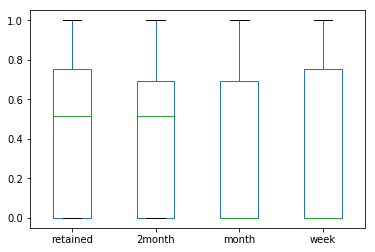

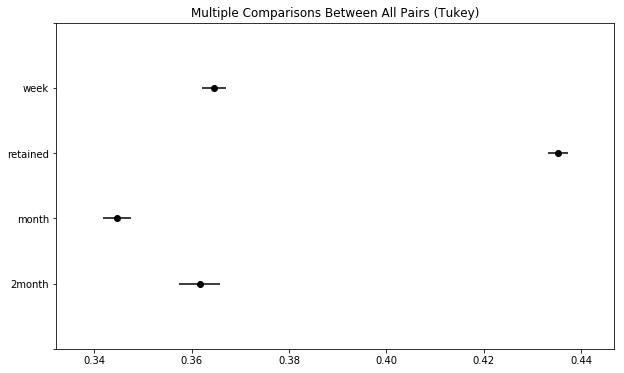

In [111]:
new_variable_checker(train_party_for_everyhour.loc[:,['new_id','hr_18','label']], train_party_for_everyhour.loc[:,'hr_18'])

/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


'변수 hr_19의 모집단은 정규분포를 따릅니다.'

                df        sum_sq     mean_sq            F  PR(>F)
label          3.0   1026.661878  342.220626  2575.094866     0.0
Residual  240020.0  31897.774237    0.132896          NaN     NaN
'통계적으로 네 집단의 차이가 유의함.'
Multiple Comparison of Means - Tukey HSD,FWER=0.10
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
 2month   month   -0.0529  -0.0597 -0.0461  True 
 2month  retained  0.0963   0.0903  0.1023  True 
 2month    week   -0.0296   -0.036 -0.0232  True 
 month   retained  0.1492   0.1445  0.1539  True 
 month     week    0.0233   0.0181  0.0285  True 
retained   week   -0.1259  -0.1301 -0.1217  True 
-------------------------------------------------



array([ True,  True,  True,  True,  True,  True])

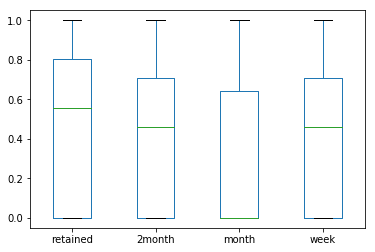

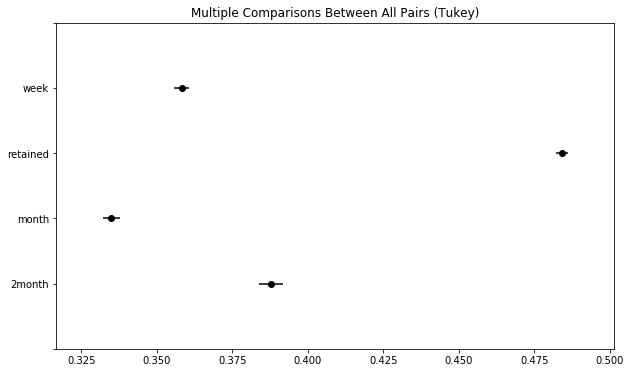

In [112]:
new_variable_checker(train_party_for_everyhour.loc[:,['new_id','hr_19','label']], train_party_for_everyhour.loc[:,'hr_19'])

/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


'변수 hr_20의 모집단은 정규분포를 따릅니다.'

                df        sum_sq     mean_sq            F  PR(>F)
label          3.0   1485.892637  495.297546  3892.275049     0.0
Residual  240020.0  30542.886989    0.127251          NaN     NaN
'통계적으로 네 집단의 차이가 유의함.'
Multiple Comparison of Means - Tukey HSD,FWER=0.10
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
 2month   month   -0.0697  -0.0763 -0.0631  True 
 2month  retained  0.1127   0.1068  0.1185  True 
 2month    week   -0.0364  -0.0427 -0.0302  True 
 month   retained  0.1824   0.1777  0.187   True 
 month     week    0.0333   0.0282  0.0384  True 
retained   week   -0.1491  -0.1532  -0.145  True 
-------------------------------------------------



array([ True,  True,  True,  True,  True,  True])

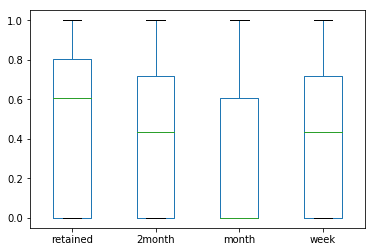

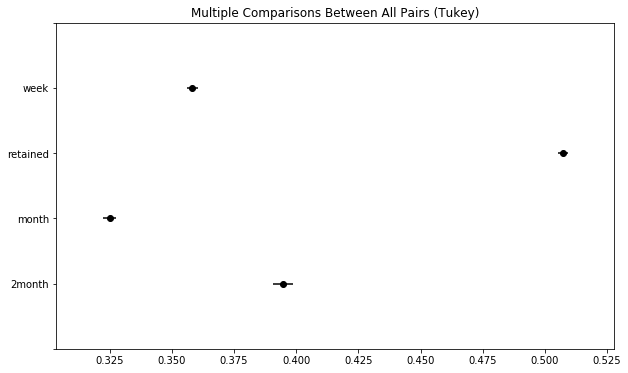

In [113]:
new_variable_checker(train_party_for_everyhour.loc[:,['new_id','hr_20','label']], train_party_for_everyhour.loc[:,'hr_20'])

/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


'변수 hr_21의 모집단은 정규분포를 따릅니다.'

                df        sum_sq     mean_sq            F  PR(>F)
label          3.0   1312.536742  437.512247  3413.446352     0.0
Residual  240020.0  30764.124806    0.128173          NaN     NaN
'통계적으로 네 집단의 차이가 유의함.'
Multiple Comparison of Means - Tukey HSD,FWER=0.10
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
 2month   month   -0.0681  -0.0747 -0.0614  True 
 2month  retained  0.1036   0.0977  0.1095  True 
 2month    week   -0.0366  -0.0429 -0.0304  True 
 month   retained  0.1717   0.167   0.1763  True 
 month     week    0.0314   0.0263  0.0366  True 
retained   week   -0.1402  -0.1444 -0.1361  True 
-------------------------------------------------



array([ True,  True,  True,  True,  True,  True])

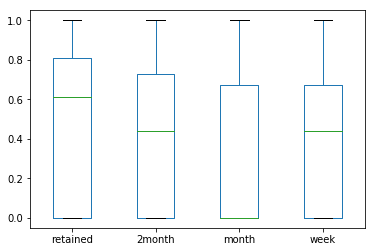

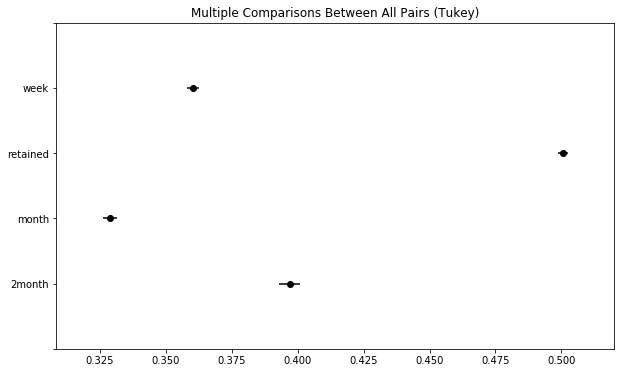

In [114]:
new_variable_checker(train_party_for_everyhour.loc[:,['new_id','hr_21','label']], train_party_for_everyhour.loc[:,'hr_21'])

/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


'변수 hr_22의 모집단은 정규분포를 따릅니다.'

                df        sum_sq     mean_sq            F  PR(>F)
label          3.0   1079.593124  359.864375  2777.042733     0.0
Residual  240020.0  31103.103384    0.129585          NaN     NaN
'통계적으로 네 집단의 차이가 유의함.'
Multiple Comparison of Means - Tukey HSD,FWER=0.10
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
 2month   month   -0.0673  -0.0739 -0.0606  True 
 2month  retained  0.0929   0.0869  0.0988  True 
 2month    week   -0.0295  -0.0359 -0.0232  True 
 month   retained  0.1601   0.1554  0.1648  True 
 month     week    0.0377   0.0325  0.0429  True 
retained   week   -0.1224  -0.1265 -0.1183  True 
-------------------------------------------------



array([ True,  True,  True,  True,  True,  True])

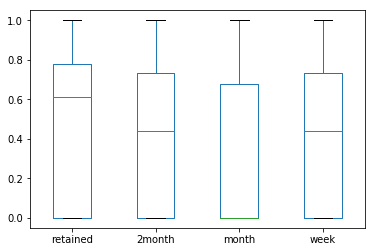

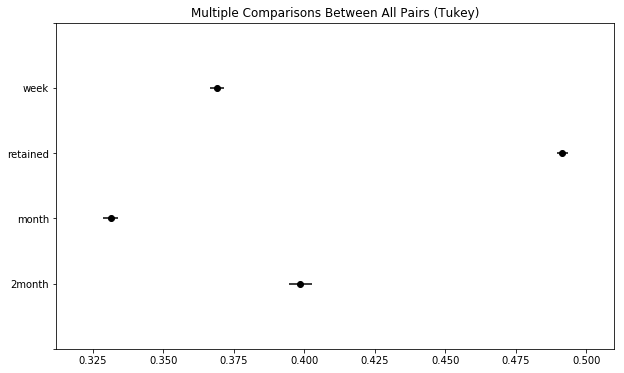

In [115]:
new_variable_checker(train_party_for_everyhour.loc[:,['new_id','hr_22','label']], train_party_for_everyhour.loc[:,'hr_22'])

/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


'변수 hr_23의 모집단은 정규분포를 따릅니다.'

                df        sum_sq     mean_sq            F  PR(>F)
label          3.0    599.532317  199.844106  1453.225466     0.0
Residual  240020.0  33006.978884    0.137518          NaN     NaN
'통계적으로 네 집단의 차이가 유의함.'
Multiple Comparison of Means - Tukey HSD,FWER=0.10
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
 2month   month   -0.0606  -0.0675 -0.0537  True 
 2month  retained  0.0659   0.0598  0.072   True 
 2month    week   -0.0157  -0.0222 -0.0091  True 
 month   retained  0.1265   0.1217  0.1313  True 
 month     week    0.045    0.0396  0.0503  True 
retained   week   -0.0816  -0.0858 -0.0773  True 
-------------------------------------------------



array([ True,  True,  True,  True,  True,  True])

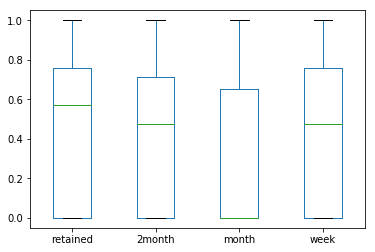

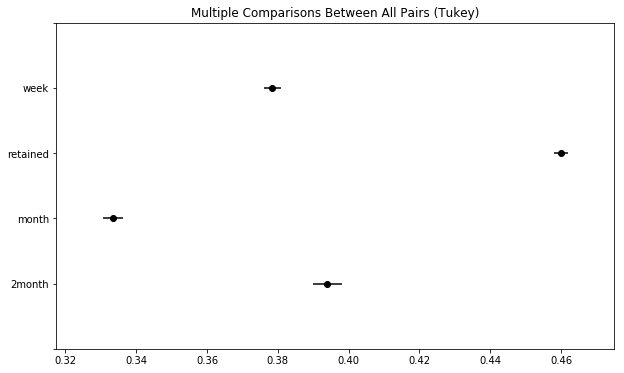

In [116]:
new_variable_checker(train_party_for_everyhour.loc[:,['new_id','hr_23','label']], train_party_for_everyhour.loc[:,'hr_23'])

### WEEK는 모든 접속시간대에 분포가 고르다

### 근데 나머지 라벨들은 새벽에 보통 잘 안하고(?) 오후부터 활발해짐

### 특히 라벨 retained는 시간별 분포가 차이가 많음.

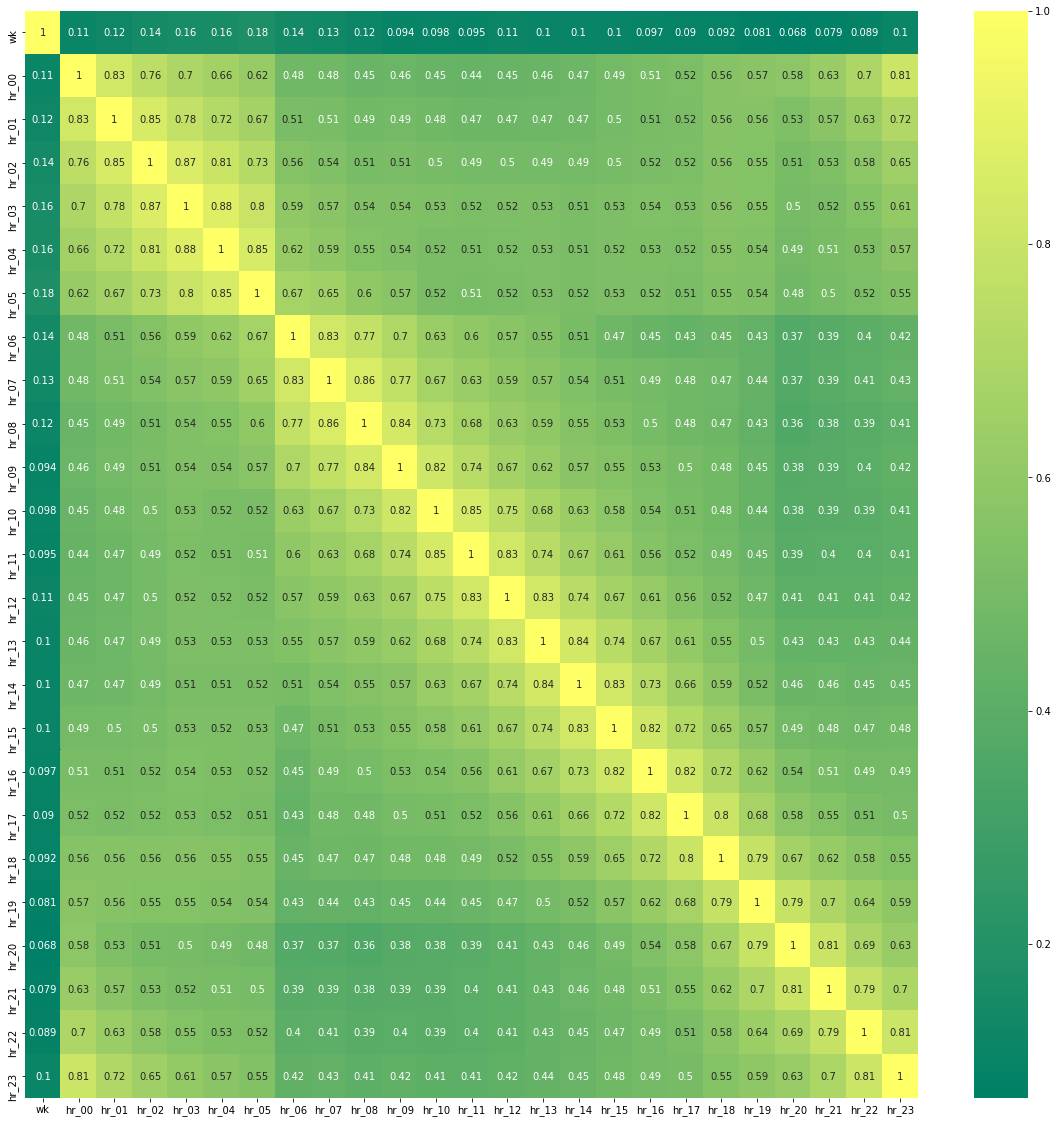

In [117]:
# 전체 유저별 시간대별 파티참여 상관 플롯

plt.figure(figsize=(20,20))
sns.heatmap(train_party_for_everyhour.corr(),cmap='summer',annot=True)

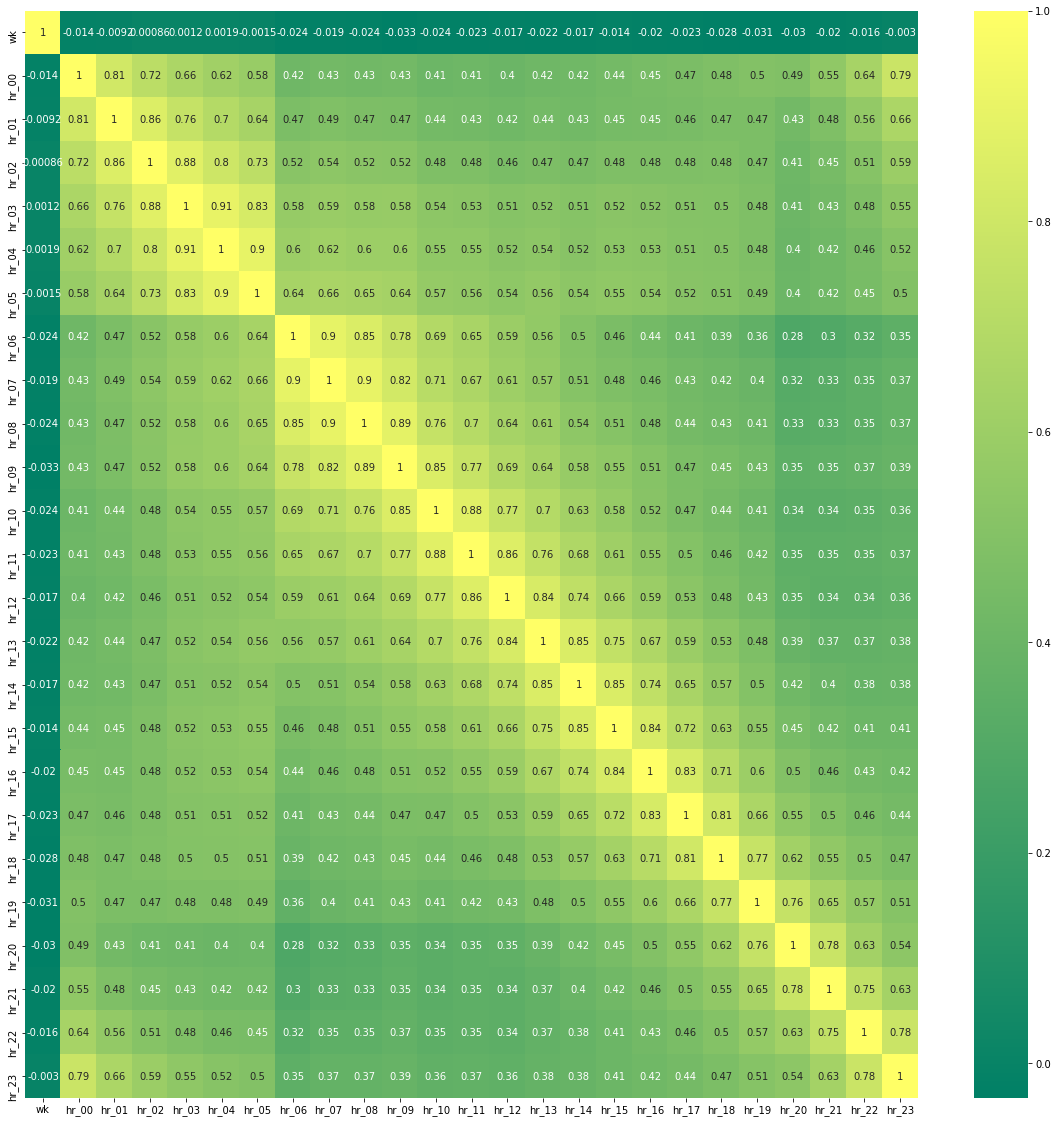

In [119]:
# retained 클래스 유저들의 시간대별 상관플롯

plt.figure(figsize=(20,20))
sns.heatmap(train_party_for_everyhour[train_party_for_everyhour.label=='retained'].corr(),cmap='summer',annot=True)

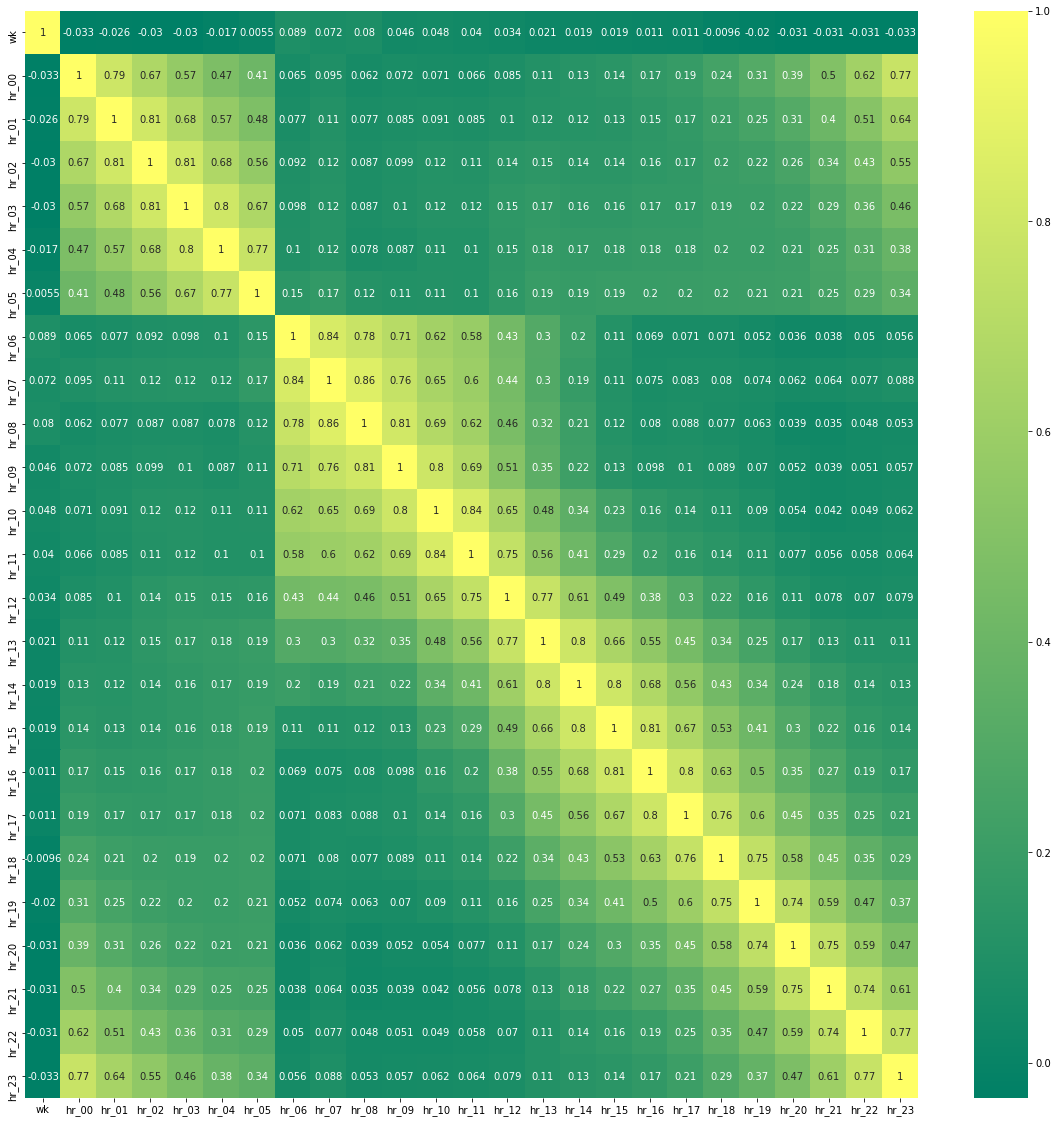

In [121]:
# 2month 클래스 유저들의 시간대별 상관플롯

plt.figure(figsize=(20,20))
sns.heatmap(train_party_for_everyhour[train_party_for_everyhour.label=='2month'].corr(),cmap='summer',annot=True)

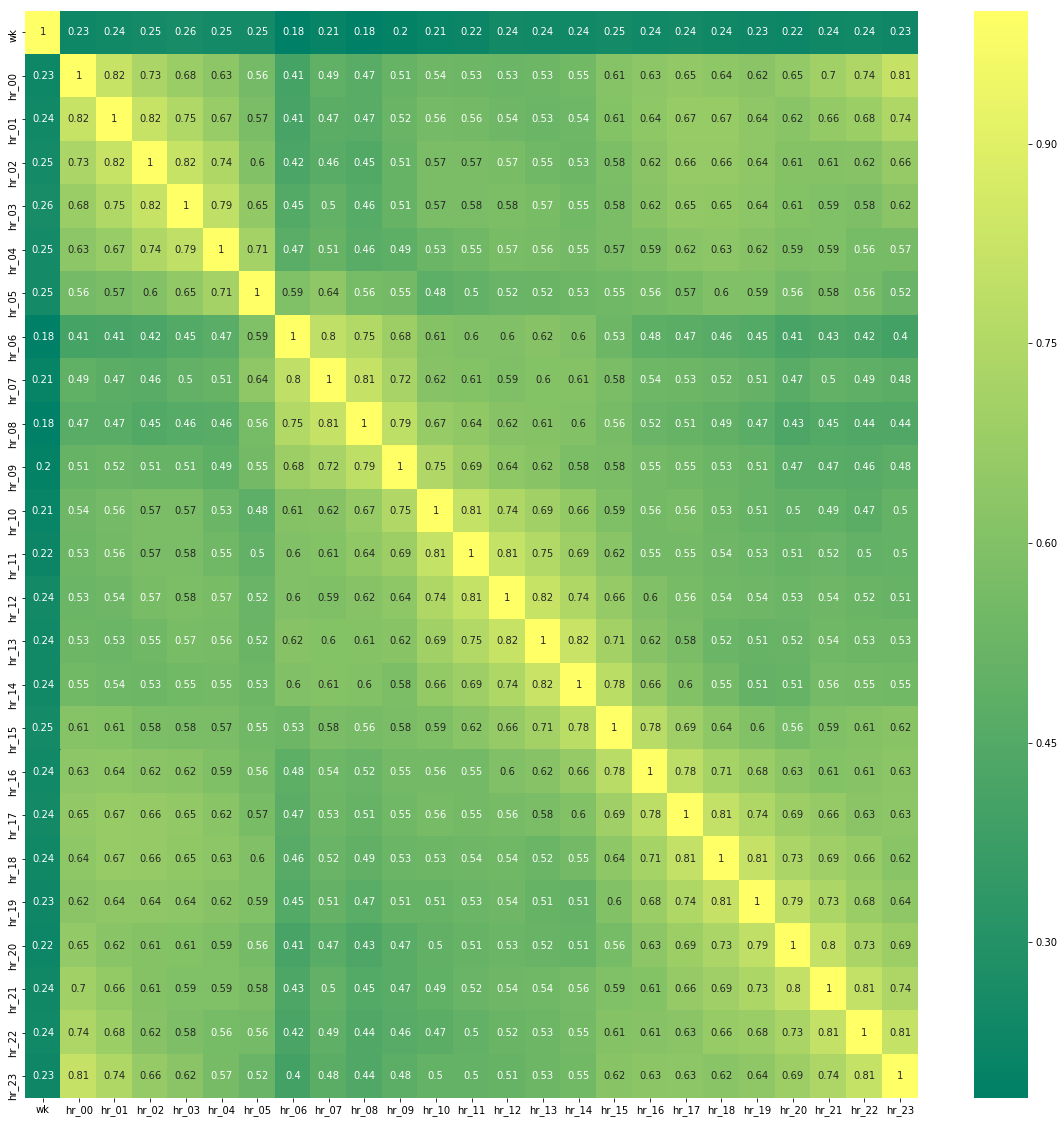

In [122]:
# month 클래스 유저들의 시간대별 상관플롯

plt.figure(figsize=(20,20))

sns.heatmap(train_party_for_everyhour[train_party_for_everyhour.label=='month'].corr(),cmap='summer',annot=True)

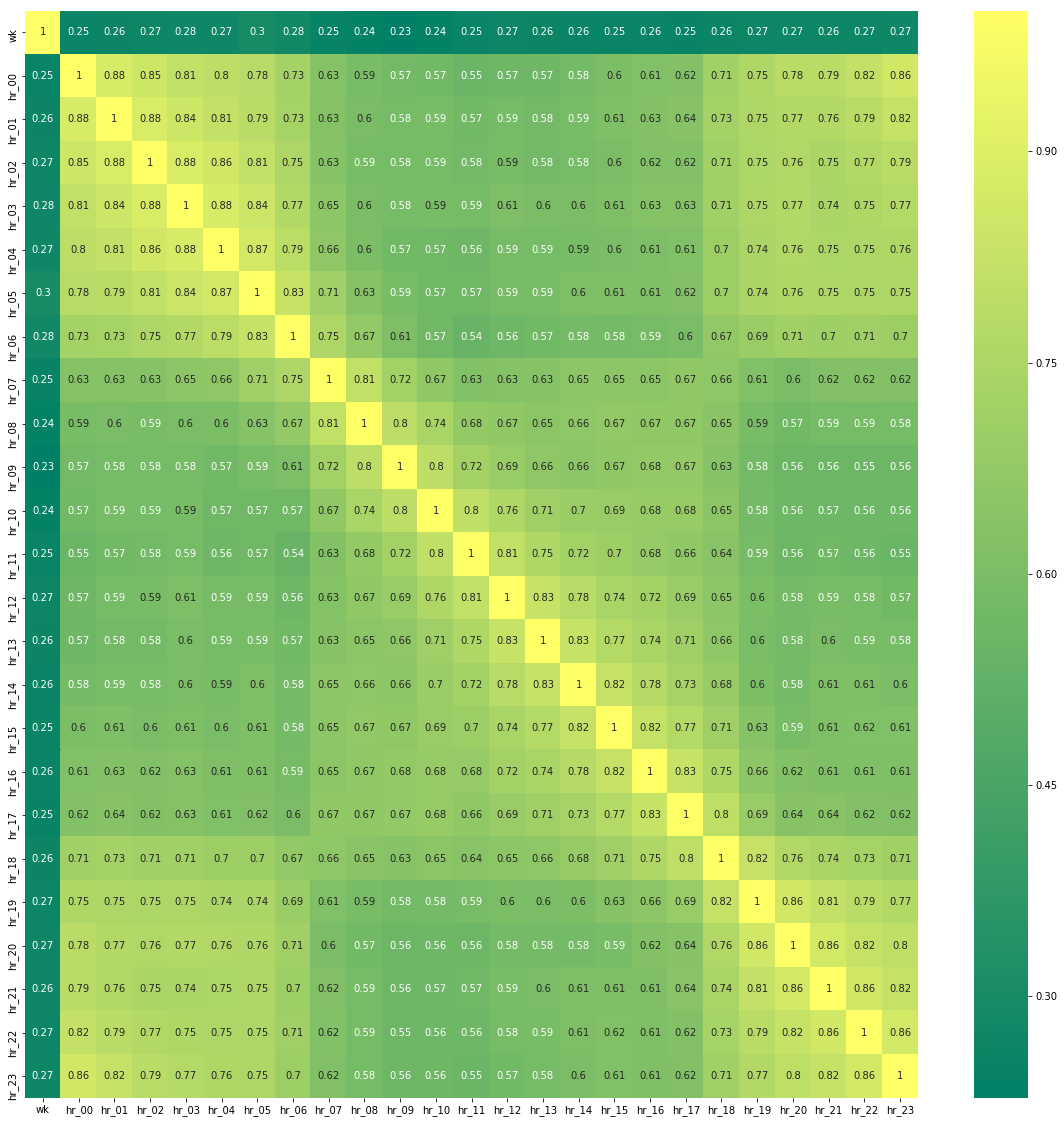

In [123]:
# week 클래스 유저들의 시간대별 상관플롯

plt.figure(figsize=(20,20))
sns.heatmap(train_party_for_everyhour[train_party_for_everyhour.label=='week'].corr(),cmap='summer',annot=True)

### 결론. 이탈 고객중. 특히 month와 week 클래스 유저들은 새벽 5시 ~6시 파티참여와 새벽 6~7시 파티참여 의 상관관계가 매우 낮다

> 아마 블레이드 앤 소울 게임이 6시에 초기화 되어 대부분의 퀘스트도 진행 가능한데 그걸 기다리는 유저가 클래스별로 그 수가 다를것이라 예상.